In [1]:
import sys
sys.path.insert(0, "../fastfeedforward")

In [2]:
!pip install tqdm matplotlib torch torchvision numpy

In [3]:
from tqdm import tqdm

import torch
import torch.nn as nn
from fff import FFF
import matplotlib.pyplot as plt

In [4]:
batch_size = 128
entropy_effect = 0.10
n_epochs = 5

leaf_width = 16
depth = 3
activation = nn.ReLU()
leaf_dropout = 0.0
region_leak = 0.0

In [5]:
# Load the MNIST dataset
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset_training = datasets.MNIST('data', download=True, train=True, transform=transform)
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=batch_size, shuffle=True)
dataset_testing = datasets.MNIST('data', download=True, train=False, transform=transform)
dataloader_testing = torch.utils.data.DataLoader(dataset_testing, batch_size=batch_size, shuffle=True)

In [6]:
# setup the FFF model
fff_model = FFF(input_width=784, leaf_width=leaf_width, output_width=10, depth=depth, activation=activation, dropout=leaf_dropout, region_leak=region_leak)

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0., return_entropies=False):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
    def forward(self, x, return_entropies: bool=False, use_hard_decisions: bool=False):
        y = self.net(x)
        return y

ffn_model = FeedForward(input_dim=784, hidden_dim=128, output_dim=10, dropout=leaf_dropout)

In [18]:
use_fff = False

if use_fff:
    model = fff_model
else:
    model = ffn_model

# train the model
training_losses = []
training_accuracies = []
training_entropies = []
epoch_testing_losses = []
epoch_testing_accuracies = []

num_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {num_params}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0

for epoch in range(n_epochs):
    print("Epoch", epoch)

    model.train()
    for batch_images, batch_labels in tqdm(dataloader_training):
        optimizer.zero_grad()

        if use_fff:
            output, node_entropies = model(batch_images.view(-1, 784), return_entropies=True)
            node_entropy_mean = node_entropies.mean()
            loss = criterion(output, batch_labels) + entropy_effect * node_entropy_mean
            training_entropies.append(node_entropy_mean.item())
        else:
            output = model(batch_images.view(-1, 784), return_entropies=False)
            loss = criterion(output, batch_labels)

        accuracy = (output.argmax(dim=1) == batch_labels).detach().float().mean()

        training_losses.append(loss.item())
        training_accuracies.append(accuracy.item())

        loss.backward()
        optimizer.step()

    # test the model
    model.eval()
    testing_losses = []
    testing_accuracies = []

    for batch_images, batch_labels in tqdm(dataloader_testing):
        output = model(batch_images.view(-1, 784))
        loss = criterion(output, batch_labels)
        accuracy = (output.argmax(dim=1) == batch_labels).detach().float().mean()

        testing_losses.append(loss.item())
        testing_accuracies.append(accuracy.item())
    epoch_testing_losses.append(sum(testing_losses) / len(testing_losses))
    acc = sum(testing_accuracies) / len(testing_accuracies)
    epoch_testing_accuracies.append(acc)

    if best_acc < acc:
        best_acc = acc

print(f"Best average accuracy achieved: {best_acc}")

Number of model parameters: 101770
Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 192.84it/s]


Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 194.67it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 194.80it/s]


Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 196.10it/s]


Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 195.72it/s]

Best average accuracy achieved: 0.9785403481012658


Text(0.5, 1.0, 'The evolution of training loss, accuracy, and mean node entropy')

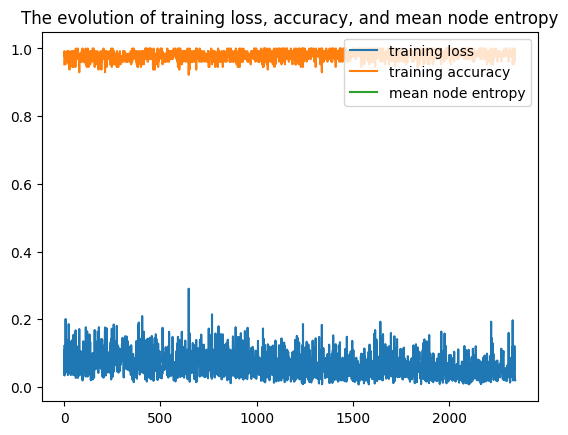

In [14]:
plt.plot(training_losses)
plt.plot(training_accuracies)
plt.plot(training_entropies)
plt.legend(["training loss", "training accuracy", "mean node entropy"], loc="upper right")
plt.title("The evolution of training loss, accuracy, and mean node entropy")

Text(0.5, 1.0, 'The evolution of testing loss and accuracy')

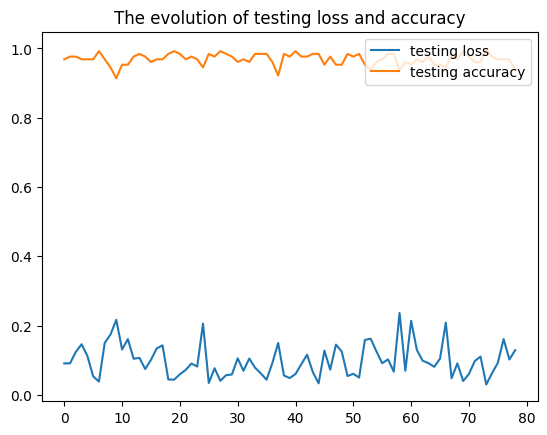

In [9]:
plt.plot(testing_losses)
plt.plot(testing_accuracies)
plt.legend(["testing loss", "testing accuracy"], loc="upper right")
plt.title("The evolution of testing loss and accuracy")

In [17]:
use_fff = True

if use_fff:
    model = fff_model
else:
    model = ffn_model

# train the model
training_losses = []
training_accuracies = []
training_entropies = []
epoch_testing_losses = []
epoch_testing_accuracies = []

num_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {num_params}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0

for epoch in range(n_epochs):
    print("Epoch", epoch)

    model.train()
    for batch_images, batch_labels in tqdm(dataloader_training):
        optimizer.zero_grad()

        if use_fff:
            output, node_entropies = model(batch_images.view(-1, 784), return_entropies=True)
            node_entropy_mean = node_entropies.mean()
            loss = criterion(output, batch_labels) + entropy_effect * node_entropy_mean
            training_entropies.append(node_entropy_mean.item())
        else:
            output = model(batch_images.view(-1, 784), return_entropies=False)
            loss = criterion(output, batch_labels)

        accuracy = (output.argmax(dim=1) == batch_labels).detach().float().mean()

        training_losses.append(loss.item())
        training_accuracies.append(accuracy.item())

        loss.backward()
        optimizer.step()

    # test the model
    model.eval()
    testing_losses = []
    testing_accuracies = []

    for batch_images, batch_labels in tqdm(dataloader_testing):
        output = model(batch_images.view(-1, 784))
        loss = criterion(output, batch_labels)
        accuracy = (output.argmax(dim=1) == batch_labels).detach().float().mean()

        testing_losses.append(loss.item())
        testing_accuracies.append(accuracy.item())
    epoch_testing_losses.append(sum(testing_losses) / len(testing_losses))
    acc = sum(testing_accuracies) / len(testing_accuracies)
    epoch_testing_accuracies.append(acc)

    if best_acc < acc:
        best_acc = acc

print(f"Best average accuracy achieved: {best_acc}")

Number of model parameters: 107336
Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.16it/s]


Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.96it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.43it/s]


Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.53it/s]


Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 111.61it/s]

Best average accuracy achieved: 0.9294897151898734


Text(0.5, 1.0, 'The evolution of training loss, accuracy, and mean node entropy')

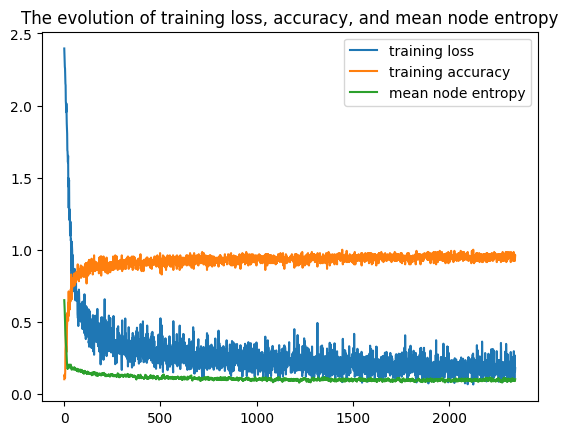

In [11]:
plt.plot(training_losses)
plt.plot(training_accuracies)
plt.plot(training_entropies)
plt.legend(["training loss", "training accuracy", "mean node entropy"], loc="upper right")
plt.title("The evolution of training loss, accuracy, and mean node entropy")

Text(0.5, 1.0, 'The evolution of testing loss and accuracy')

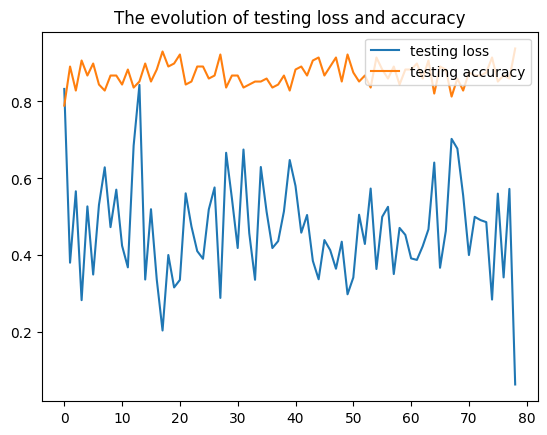

In [12]:
plt.plot(testing_losses)
plt.plot(testing_accuracies)
plt.legend(["testing loss", "testing accuracy"], loc="upper right")
plt.title("The evolution of testing loss and accuracy")